![obspy logo](img/obspy-logo.png)

# Introducción

ObsPy es un módulo para Python que facilita procesar datos sismológicos. Provee rutinas para cargar archivos, descargarlos de respositorios y procesar las señales. Con él, vamos a poder desarrollar rápida y facilmente nuestros propios programas. 

Toda la documentación relacionada con el proyecto la podemos encontrar en este [enlace](http://docs.obspy.org/).

Como todo módulo, para poder usarlo primero debemos importarlo. 

In [1]:
import obspy

Hay dos formas de cargar un sismograma a memoria. Puede que ya lo tengamos local, entonces es como leer cualquier otro archivo. O bien, podemos utilizar las funciones de Obspy para descargarlo desde algún repositorio, como IRIS. 

Intentemos primero accederlo vía web. Vamos a utilzar de ejemplo el sismo de Jacó de hace unos días. Podemos utilizar [Wilber](http://ds.iris.edu/wilber3/find_event) para encontra el evento. De cualquier manera, los parámetros son:

Ahora vamos a utilizar esta información para descargar la forma de onda de la estación `JACO` 1 minuto antes del evento y 10 minutos después. Primero debemos crear un *cliente*. Seguidamente, vamos a utilizar el método `get_waveforms` para descargar la componente vertical de la onda. Puede encontrar más información del métido [aquí](https://docs.obspy.org/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms.html#obspy.clients.fdsn.client.Client.get_waveforms). 

In [2]:
import obspy.clients.fdsn as fdsn
client = fdsn.Client('IRIS')

# defino el momento del evento y el inicio y fin de la onda. 
event_time = obspy.UTCDateTime('20171113022824')
start_time = event_time - 60
end_time   = event_time + 60*10

# Utilizo el cliente para obtener la onda
jaco = client.get_waveforms('OV', 'JACO', '*', 'HHZ', start_time, end_time, attach_response=True)

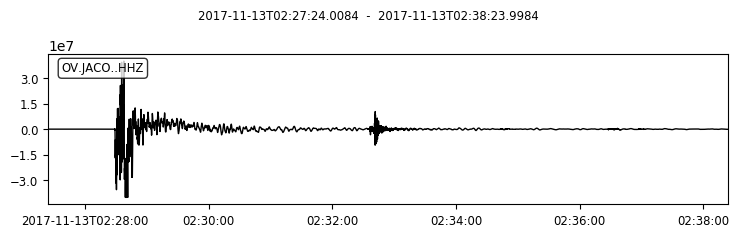

In [3]:
jaco.plot()

Note el último parámetro del método, `attach_response`, con esto le pedimos al servidor que nos envíe también la información necesaria para eliminar la respuesta del instrumento. Esto lo haremos más tarde.

### Ejercicio 

Seleccione alguna otra estación de la red del OVSICORI y visualize el evento. Solo requiere cambiar el parámetro `JACO` en el método anterior. Puede encontrar la lista completa de estaciones [aquí](http://www.ovsicori.una.ac.cr/index.php/sismologia/mapa-estaciones). También puede modificar cual componente de la onda quiere observar o incluso la red. El código de red de la RSN es `TC`, [aquí](http://rsn.ucr.ac.cr/rsn/doi) puede encontrar la lista de estaciones. 

In [5]:
wave = client.get_waveforms('?', 'PAS', '*', 'HHZ', start_time, end_time, attach_response=True)
wave.plot()

FDSNNoDataException: No data available for request.
Detailed response of server:



Ahora, vamos a repetir el procedimiento, pero con datos locales. En este mismo directorio debería encontrar un directorio llamado `datos`. Ahí puede encontrar el archivo `jaco-solo_jaco.tar.mseed`. Es la forma de onda del mismo evento en formato mini-seed. Podemos cargarla con el siguiente código:

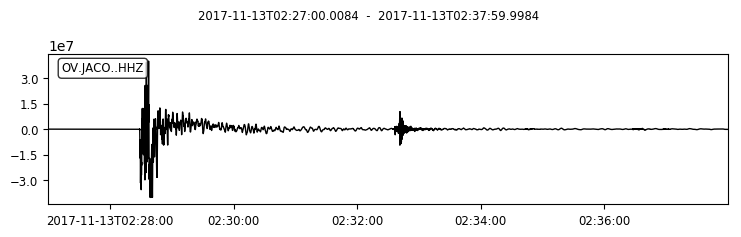

In [6]:
jaco = obspy.read('datos/jaco-solo_jaco.tar.mseed')
jaco.plot()

## Conversión de formatos

Existen ya muchos programas para trabajar las señales de los sismómetros. En general, queremos usarlos tanto como podamos. Es común que las señales estén almacenadas en un formato, pero el programa las consuma en otro. Obspy nos puede ayudar a pasar de un formato a otro. Para ello utilizamos las funciones [read()](https://docs.obspy.org/packages/autogen/obspy.core.stream.read.html) y [write()](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.write.html). 

### Ejercicio

Abra el archivo `jaco-solo_jaco.tar.mseed` y guárdelo en formato `SAC`. 

In [7]:
name = 'jaco-solo_jaco.tar.mseed'

# Abra el archivo con read()
wave = obspy.read('datos/jaco-solo_jaco.tar.mseed')

new_name = name.replace('tar.mseed', 'sac')
# Guarde el archivo con write(), en formato SAC
wave.write(new_name)

## Objeto `Trace`

Obspy nos ofrece dos objetos para manejar los datos. 

El objeto `Trace` es la base de todo Obspy. En esencia es un arreglo de Numpy con metadatos. [Aquí](https://docs.obspy.org/packages/autogen/obspy.core.trace.Trace.html#obspy.core.trace.Trace) puede encontrar la documentación del objeto. Tiene tres parámetros:

| Parámetro | Descripción | 
|-----------|-------------|
|`id`       | Identificador compatible con `SEED` |
|`stats`    | Diccionario con metadatos |
|`data`     | Arreglo de Numpy con los datos |


### Ejercicio

Carge de nuevo el archivo `jaco-solo_jaco.tar.mseed` y examine sus parámetros, en especial el diccionario `stats`.

In [8]:
wave = obspy.read('datos/jaco-solo_jaco.tar.mseed')[0]
print('ID: ' + str(wave.id))
print('STATS: ' + str(wave.stats))
print('Data: ' + str(wave.data))

ID: OV.JACO..HHZ
STATS:          network: OV
         station: JACO
        location: 
         channel: HHZ
       starttime: 2017-11-13T02:27:00.008400Z
         endtime: 2017-11-13T02:37:59.998400Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 66000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'M', 'number_of_records': 434, 'encoding': 'STEIM2', 'byteorder': '>', 'record_length': 512, 'filesize': 222208})
Data: [  14611   14609   14558 ..., -125282 -122561 -122301]


El objeto `Trace` incluye muchos métodos útiles. Usaremos varios de ellos en las siguienes secciones.

## Objeto `Stream`

El objeto `Stream` se parece a una lista. Agrupa varias señales (objetos `Trace`) de diferentes sismómetros o del mismo sismómetro pero diferentes periodos. Puede encontrar la documentación [aquí](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.html#obspy.core.stream.Stream). En general le vamos a aplicar el mismo procedimiento a muchas señales, por ejemplo, las vamos a filtrar con las mismas frecuencias de corte. El objeto `Stream` nos permite aplicar el mismo procedimiento a todos las señales con solo una línea de código. 

Podemos cargar todas las señales registradas en IRIS durante el sismo de Jacó, estas se encuentran en el archivo `jaco-todas_las_estaciones.tar.mseed`. 

In [10]:
jaco_waves = obspy.read('datos/jaco-todas_las_estaciones.tar.mseed')
print(jaco_waves.__str__(extended=True))

30 Trace(s) in Stream:
OV.BATAN..HHZ | 2017-11-13T02:27:00.008400Z - 2017-11-13T02:37:59.998400Z | 100.0 Hz, 66000 samples
OV.CDITO..HHZ | 2017-11-13T02:27:00.008400Z - 2017-11-13T02:37:59.998400Z | 100.0 Hz, 66000 samples
OV.CDM..HHZ   | 2017-11-13T02:27:00.008400Z - 2017-11-13T02:37:59.998400Z | 100.0 Hz, 66000 samples
OV.COVE..HHZ  | 2017-11-13T02:27:00.008400Z - 2017-11-13T02:37:59.998400Z | 100.0 Hz, 66000 samples
OV.CPMI..HHZ  | 2017-11-13T02:27:00.008400Z - 2017-11-13T02:37:59.998400Z | 100.0 Hz, 66000 samples
OV.DUNO..HHZ  | 2017-11-13T02:27:00.008400Z - 2017-11-13T02:35:16.958400Z | 100.0 Hz, 49696 samples
OV.DUNO..HHZ  | 2017-11-13T02:35:18.968400Z - 2017-11-13T02:37:59.998400Z | 100.0 Hz, 16104 samples
OV.GRZA..HHZ  | 2017-11-13T02:27:00.005000Z - 2017-11-13T02:37:59.995000Z | 100.0 Hz, 66000 samples
OV.HDC3..HHZ  | 2017-11-13T02:27:00.000000Z - 2017-11-13T02:38:00.000000Z | 100.0 Hz, 66001 samples
OV.INDI..HHZ  | 2017-11-13T02:27:00.005000Z - 2017-11-13T02:37:59.995000Z | 1

 Al ser *como una lista*, el objeto `Stream` es iterable. El siguiente código recorre todos los `Trace` almacenados en `jaco_waves` e imprime su id y longitud de los datos

In [11]:
for t in jaco_waves:
    print(str(t.id) + ' ' + str(len(t.data)))  

OV.BATAN..HHZ 66000
OV.CDITO..HHZ 66000
OV.CDM..HHZ 66000
OV.COVE..HHZ 66000
OV.CPMI..HHZ 66000
OV.DUNO..HHZ 49696
OV.DUNO..HHZ 16104
OV.GRZA..HHZ 66000
OV.HDC3..HHZ 66001
OV.INDI..HHZ 66000
OV.JACO..HHZ 66000
OV.JUDI..HHZ 66001
OV.LAFE..HHZ 66001
OV.MRVA..HHZ 66001
OV.NARJ..HHZ 66000
OV.OCHAL..HHZ 66000
OV.OCM..HHZ 66000
OV.ORTG..HHZ 66000
OV.POTG..HHZ 66000
OV.RIFO..HHZ 66000
OV.RIMA..HHZ 66000
OV.RIOS..HHZ 66000
OV.VACR..HHZ 66001
OV.VIMO..HHZ 66001
OV.VMAR..HHZ 66000
OV.VPTE..HHZ 66001
OV.VTCV..HHZ 66001
OV.VTLA..HHZ 66001
OV.VTLO..HHZ 66001
OV.VTRT..HHZ 66001


Note que la estación `DUNO` aparce dos veces. La suma de la longitud de las dos apariciones es 66000, el mismo número de muestras que contienen el resto de estaciones. Esto se debe a discontinuidades en la señal, puede ser por que se perdió o variaciones en la frecuencia de muestreo. Estos eventos aleatorios son comunes y Obspy incluye funciones para manejarlos. 

### Ejercicio

Investigue la función `obspy.stream.merge()` y utilícela para resolver el asunto con la estación `DUNO`. Imprima de nuevo la lista de estaciones y la longitud de los datos. 

In [ ]:
# Utilice la función merge
jaco_waves.merge()

# Imprima las estaciones
for t in jaco_waves:
    print(str(t.id) + ' ' + str(len(t.data))) 